In [176]:
using Plots
using LaTeXStrings
using LinearAlgebra
using Random
using Distributions
using FFTW
# using Pkg
# Pkg.add("AbstractGPs")
# Pkg.add("LogExpFunctions")
using AbstractGPs, LogExpFunctions, Turing
using Pkg
# Pkg.add("InducingPoints")
using InducingPoints


In [2]:
function meshgrid(x,y)
    n = length(y)
    m = length(x)
    X = Matrix{eltype(x)}(undef, n, m)
    Y = Matrix{eltype(y)}(undef, n, m)
    @views @simd for i in eachindex(y)
        X[i,:] = x
    end
    @views @simd for j in eachindex(x)
        Y[:,j] = y
    end
    return X, Y
end
function fftnshift(A::AbstractArray)
    B = copy(A)
    return fftshift(fft(fftshift(B)))
end
function ifftnshift(A::AbstractArray)
    B = copy(A)
    return fftshift(ifft(ifftshift(B)))
end
function Autocorrelation(image)
    # the image is assumed to be in real space
    
    image_fft = fftnshift(image)
    image_auto = ifftnshift(image_fft .* conj.(image_fft))
    if eltype(image) <: Real 
        return real.(image_auto)
    end
    return image_auto
end

Autocorrelation (generic function with 1 method)

In [205]:
gaussian(x, σ) = @. exp(-x^2 / (2σ^2)) / (σ * sqrt(2π))
Random.seed!(1)
# n = 35
n = 100
N_electrons = 10_00
L = 20
ϵ = 0.01
y_latent = zeros(n)
x_train = collect(LinRange(0.0, L, n))
for i in 1:5
    x0 = rand(Uniform(0, L))
    σ = rand(truncated(Normal(0, 1), 0.1, 1))
    y_latent += gaussian(x_train.-x0, σ) #.+ ϵ * randn(n)
end
# y_latent += ϵ * randn(n)
println(size(y_latent))
println(size(x_train))





Intensity = 2 .+ cos.(y_latent)
y_train = rand.(Poisson.(Intensity*N_electrons));



(100,)
(100,)


35


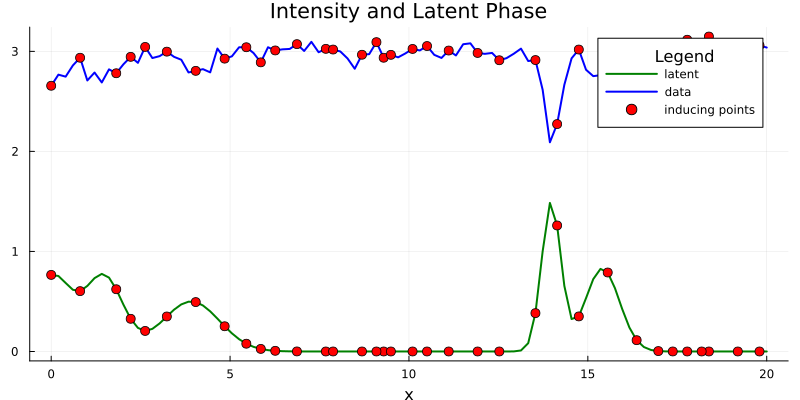

In [383]:
M = 35
s = 5
kernel = 4*with_lengthscale(SqExponentialKernel(), 0.2)
noise = 1e-6
alg = Greedy(35, s)
# alg = GreedyVarSelection(100, 1e-6)

Z = inducingpoints(alg, x_train; y=y_train, kernel, noise)
# Z = inducingpoints(alg, y_train; kernel=kernel)
println(length(Z))
Z_indices = [findmin(abs2.(x_train .- z_i))[2] for z_i in Z]

plot(x_train, y_latent, 
    label = "latent", 
    title = "Intensity and Latent Phase", 
    xlabel = "x", ylabel = "",
    markersize = 2, size = (800, 400), color = :green, linewidth = 2)
plot!(x_train, y_train./N_electrons, 
    label = "data", 
    markersize = 2, 
    color = :blue, linewidth = 2)
scatter!(x_train[Z_indices], y_latent[Z_indices], 
    label = "inducing points", 
    markersize = 5, 
    color = :red, linewidth = 2)
scatter!(x_train[Z_indices], y_train[Z_indices]./N_electrons, 
    label = "", 
    markersize = 5, 
    color = :red, linewidth = 2)
plot!(legend = :topright, legendtitle = "Legend",)

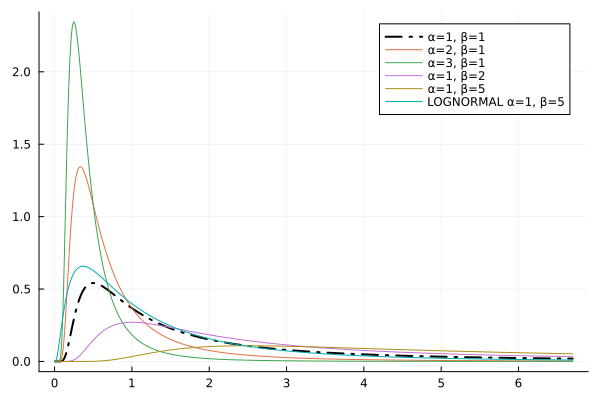

In [ ]:
# using Pkg
# Pkg.add("KernelDensity")
using Distributions, StatsPlots, KernelDensity


# dist = Normal(0, 1)

# Generate the samples
samples = rand(dist, 10^6)




# Optional: Add theoretical PDF of InverseGamma(1,1)
if minimum(samples) < 0
    x_range = range(quantile(samples,0.05), quantile(samples, 0.95), length=1000)
else
    x_range = range(0.0, quantile(samples, 0.99), length=1000)
end

IG(α, β) = InverseGamma(α, β)
fig = plot(x_range, pdf.(IG(1,1), x_range), 
      label="α=1, β=1",
      linewidth=2, 
      color=:black,
      linestyle=:dashdot)
plot!(x_range, pdf.(IG(2,1), x_range), 
    label="α=2, β=1")
plot!(x_range, pdf.(IG(3,1), x_range),
    label="α=3, β=1")   


plot!(x_range, pdf.(IG(1,2), x_range), 
    label="α=1, β=2")
plot!(x_range, pdf.(IG(1,5), x_range),
    label="α=1, β=5") 
plot!(x_range, pdf.(LogNormal(0,1), x_range),
    label="LOGNORMAL α=1, β=5") 

display(fig)



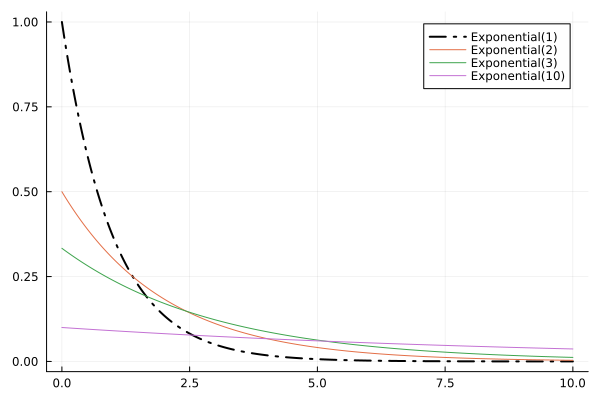

In [121]:
x_range = range(0.0, 10.0, length=1000)
fig = plot(x_range, pdf.(Exponential(1), x_range), 
      label="Exponential(1)",
      linewidth=2, 
      color=:black,
      linestyle=:dashdot)
plot!(x_range, pdf.(Exponential(2), x_range),
    label="Exponential(2)")
plot!(x_range, pdf.(Exponential(3), x_range),
    label="Exponential(3)")
plot!(x_range, pdf.(Exponential(10), x_range),
    label="Exponential(10)")

Log-transformed KDE mode: 1.061737047337017


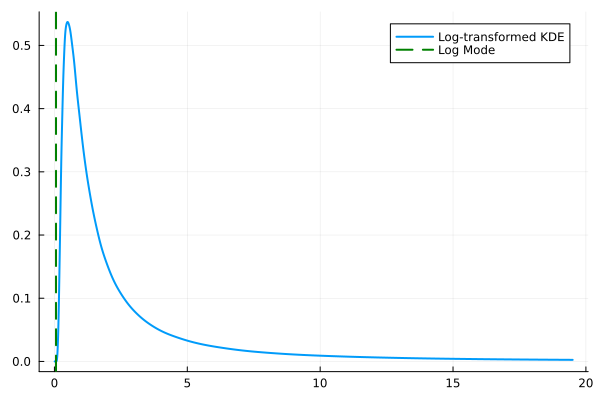

In [94]:
# Option 1: Apply KDE on log-transformed data
# First define the log-transformed KDE and calculate densities
log_samples = log.(samples)
kde_log = kde(log_samples)
x_grid = range(log(0.001), log(quantile(samples, 0.999)), length=1000)
density_est = pdf(kde_log, x_grid)

# Find the mode in log space
max_log_density_idx = argmax(density_est)
log_mode = x_grid[max_log_density_idx]

# Transform back to original scale
mode_value = exp(log_mode)
println("Log-transformed KDE mode: $mode_value")

plot(x_orig, density_orig, label="Log-transformed KDE", linewidth=2)
vline!([log_mode], label="Log Mode", linewidth=2, color=:green, linestyle=:dash)

# plot!(x_range, pdf.(dist, x_range), label="True density", linewidth=2)

# # Option 2: Use adaptive bandwidth
# using KernelEstimator  # You may need to install this
# kde_adaptive = kde(samples, kernel=:epanechnikov, bandwidth=:local)

In [10]:
# using BSplines
# using Pkg
# # Pkg.add("StatsFuns")
# spacing = 2
# order = 3  # Cubic B-splines
# N_knots = length(x_train[1:spacing:end])
# knots_list = x_train[1:spacing:end]
# basis = BSplineBasis(order, knots_list)
# N_basis = length(basis)
Link(z) = π/2 * logistic(z)

Link (generic function with 1 method)

In [170]:
using ReverseDiff
using Turing
using BSplines
using Statistics: mean, median



@model function latent_model(y, x_input, N_poisson, λ)
    # λ_test ~ LogNormal(0.0, 10.0) # λ ~ InverseGamma(1, 1)
    # l_inv ~ InverseGamma(1, 2)
    # l ~ InverseGamma(1, 1)
    l ~ LogNormal(0.0, 1.0)
    # l2 ~ InverseGamma(1, 5)

    # v ~ Exponential(10)
    v ~ truncated(Normal(0, 5), 0.0, Inf)
    # v2 ~ Exponential(10)

    # f = GP(v * with_lengthscale(SEKernel(), inv(l_inv)))
    f = GP(v * with_lengthscale(SEKernel(), l))

    jitter = 1e-6
    f_latent ~ f(x_input, jitter)
    wrapped = @. Link(f_latent)
    I = @. (2 + cos(wrapped))* N_poisson
    

    y ~ arraydist(Poisson.(I))
end

# λs = collect(LinRange(0.0, 1000, 10));
model = latent_model(y_train, x_train, N_electrons, 50)
# sampler = Turing.NUTS(max_depth=8; adtype=AutoReverseDiff(true))
sampler = Turing.NUTS(max_depth=8; adtype=AutoForwardDiff())

chain = sample(model, sampler, 2000; progress=true)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.000732421875
└ @ Turing.Inference /home/nicolas/.julia/packages/Turing/IXycm/src/mcmc/hmc.jl:207
Sampling   0%|▎                                         |  ETA: 0:17:20
Sampling   1%|▍                                         |  ETA: 0:14:58
Sampling   2%|▋                                         |  ETA: 0:15:06
Sampling   2%|▉                                         |  ETA: 0:14:39
Sampling   2%|█                                         |  ETA: 0:14:22
Sampling   3%|█▎                                        |  ETA: 0:14:21
Sampling   4%|█▌                                        |  ETA: 0:14:09
Sampling   4%|█▋                                        |  ETA: 0:13:45
Sampling   4%|█▉                                        |  ETA: 0:13:29
Sampling   5%|██▏                                       |  ETA: 0:13:20
Sampling   6%|██▎                                       |  ETA: 0:12:21
S

Chains MCMC chain (2000×49×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 138.66 seconds
Compute duration  = 138.66 seconds
parameters        = l, v, f_latent[1], f_latent[2], f_latent[3], f_latent[4], f_latent[5], f_latent[6], f_latent[7], f_latent[8], f_latent[9], f_latent[10], f_latent[11], f_latent[12], f_latent[13], f_latent[14], f_latent[15], f_latent[16], f_latent[17], f_latent[18], f_latent[19], f_latent[20], f_latent[21], f_latent[22], f_latent[23], f_latent[24], f_latent[25], f_latent[26], f_latent[27], f_latent[28], f_latent[29], f_latent[30], f_latent[31], f_latent[32], f_latent[33], f_latent[34], f_latent[35]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
    parameters      mean       std      mcse    ess_bulk    ess_tail   

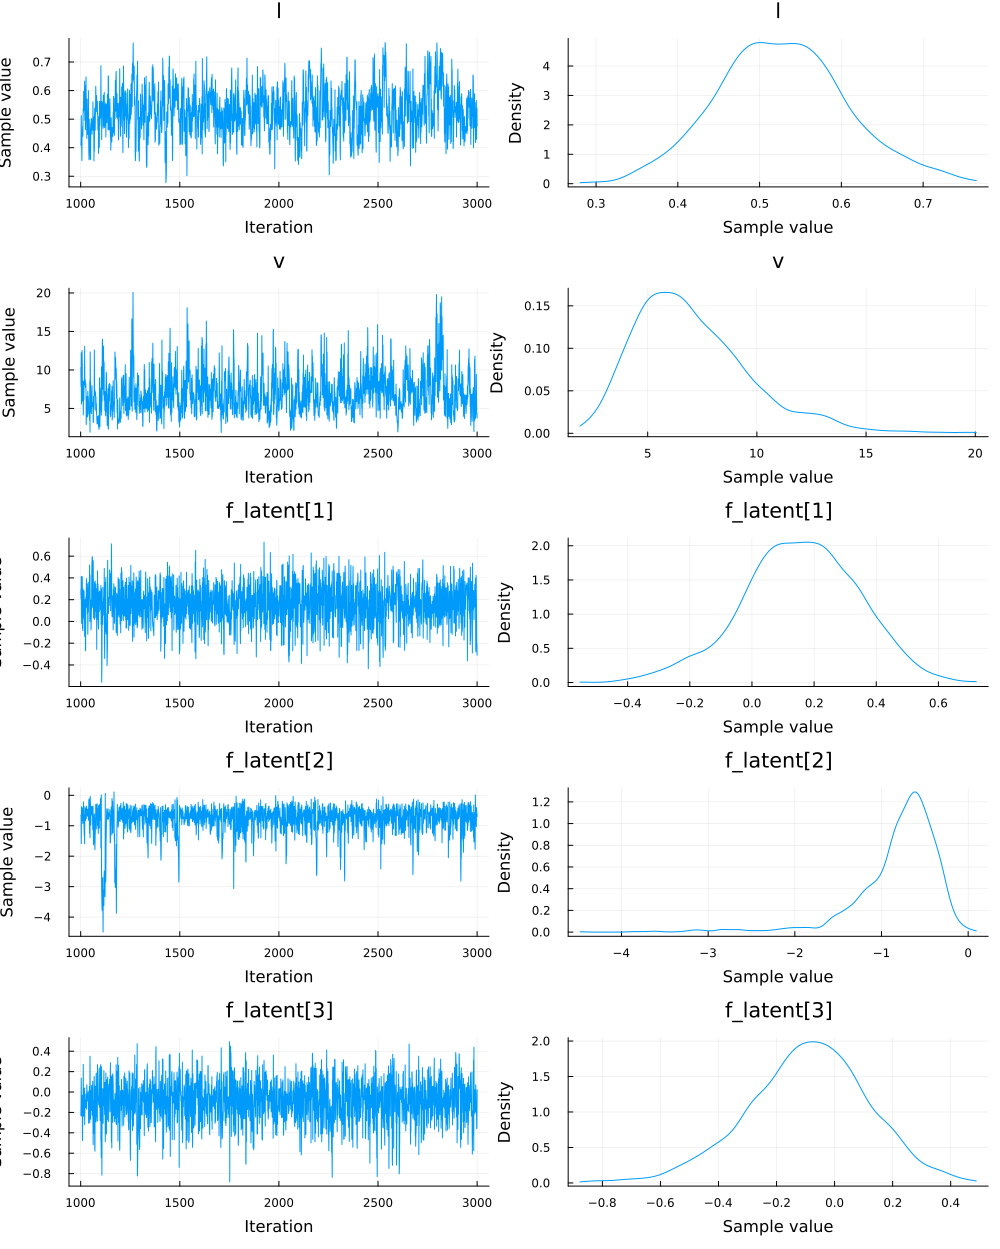

In [171]:
using StatsPlots
plot(chain[:,1:5,1])
# plot(chain[:,10:15,1])

In [172]:
fig1 = plot(x_train, y_latent, 
        # label = "λ = $(λs[1])", 
        markersize = 2, color = :black, linewidth = 3)
fig2 = plot()
n_spacing = 5
phis_reconstructed = Matrix{Float64}(undef, length(1000:n_spacing:2000), length(x_train))
weights_reconstructed = Matrix{Float64}(undef, length(1000:n_spacing:2000), length(x_train))
for (k,k_val) in enumerate(1000:n_spacing:2000)
    weight_values = [chain[k_val, Symbol("f_latent[$i]"), 1] for i in 1:length(x_train)]
    # reconstructed_spline = Spline(basis, weight_values)
    phi_reconstructed = @. Link(weight_values)
    phis_reconstructed[k, :] = phi_reconstructed
    weights_reconstructed[k, :] = weight_values

    # println(length(weight_values[1:end-1]))
    # println(length(x_train[1:spacing:end]))
    # @assert length(weight_values[1:end-1]) == length(x_train[1:spacing:end])

    plot!(fig1, x_train, phi_reconstructed, 
        title = "Posterior samples of weights", 
        xlabel = "", ylabel = "", 
        markersize = 2, color = :green, linewidth = 2, alpha =0.05)

    plot!(fig2, x_train, weight_values, 
        title = "Posterior samples of weights", 
        xlabel = "", ylabel = "", 
        markersize = 2, color = :blue, linewidth = 2, alpha =0.1)

end
# plot!(legend=false)
println(size(phis_reconstructed))
phi_mean  = median(phis_reconstructed, dims = 1) |> vec               # N-vector
phi_mean  = mapslices(p -> quantile(p, 0.50), phis_reconstructed; dims = 1) |> vec
phi_low   = mapslices(p -> quantile(p, 0.15), phis_reconstructed; dims = 1) |> vec
phi_high  = mapslices(p -> quantile(p, 0.85), phis_reconstructed; dims = 1) |> vec
w_mean  = median(weights_reconstructed, dims = 1) |> vec               # N-vector
w_mean   = mapslices(p -> quantile(p, 0.50), weights_reconstructed; dims = 1) |> vec
w_low   = mapslices(p -> quantile(p, 0.15), weights_reconstructed; dims = 1) |> vec
w_high  = mapslices(p -> quantile(p, 0.85), weights_reconstructed; dims = 1) |> vec


plot!(fig1, x_train, (phi_mean);
    ribbon = (phi_mean .- phi_low, phi_high .- phi_mean),   # symmetric ribbon
    label  = "posterior mean",
    title = "Phase reconstructed",  # Added comma here
    xlabel = "x", ylabel = "f(x)",
    legend = :topleft, lw = 3, color=:green);
plot!(fig2, x_train, (w_mean);
    ribbon = (w_mean .- w_low, w_high .- w_mean),   # symmetric ribbon
    label  = "posterior mean",
    xlabel = "x", ylabel = "f(x)",
    legend = :topleft, lw = 3);




(201, 35)


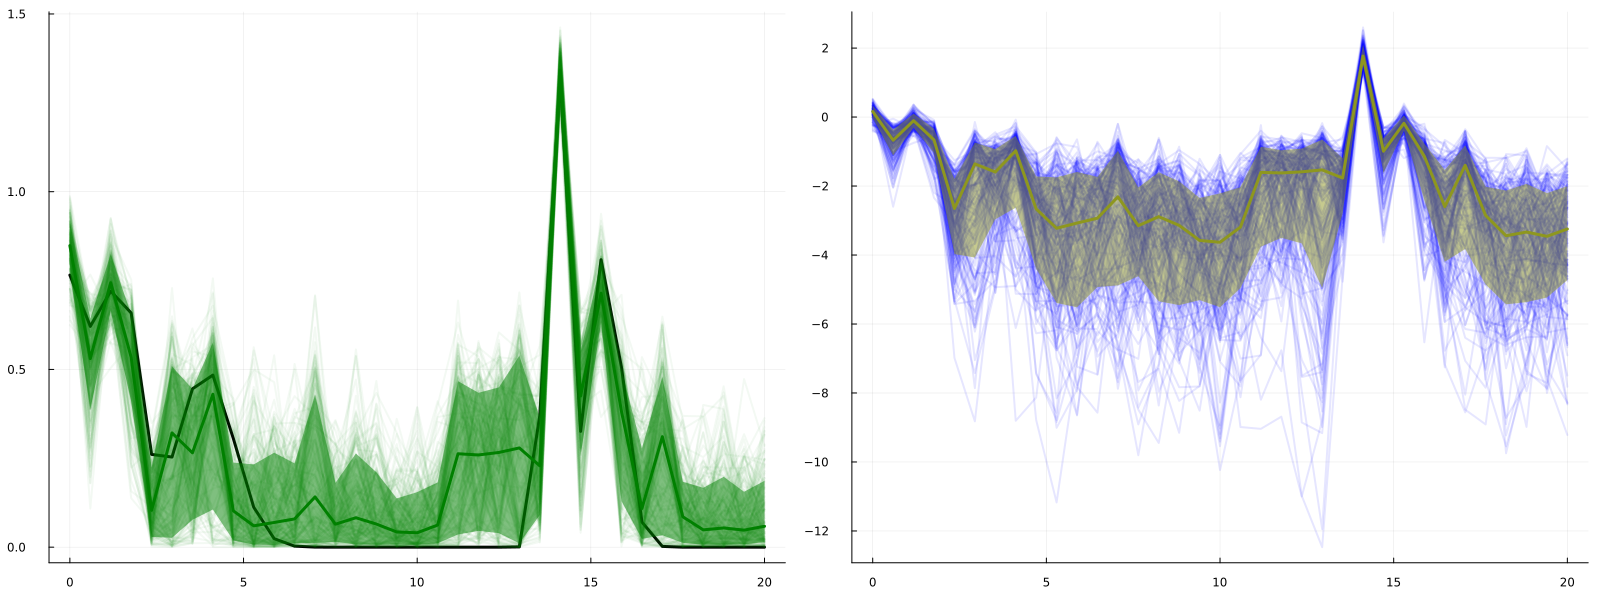

In [173]:
plot(fig1, fig2, layout = (1, 2), size = (1600, 600), 
    title = "", 
    xlabel = "x", ylabel = "", 
    label = ["latent" "weights"], legend = false)


In [27]:
color_gradient = cgrad(:viridis, length(λs), categorical=true)
fig1 = plot()
for (i,lambda_val) in enumerate(λs)
    plot!(x_train[1:spacing:end], weights_samples[i, 1:end-1],
        title = "Latent Phase", 
        xlabel = "λ", 
        ylabel = "latent phase",
        label = "λ = $(round(lambda_val, digits=2))",
        markersize = 2, 
        size = (800, 400),
        color = color_gradient[i],
        linewidth = 2)
end
display(fig1)

UndefVarError: UndefVarError: `λs` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [28]:
lp = copy(latent_phis);

UndefVarError: UndefVarError: `latent_phis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [29]:
# fig1 = plot() 
color_gradient = cgrad(:viridis, length(λs), categorical=true)

# for (i, lambda_val) in enumerate(λs)
#     plot!(x_train, latent_phis[i, :],
#           label = "λ = $(round(lambda_val, digits=2))",
#           markersize = 2, color = :blue, linewidth = 2)
# end
fig1 = plot(title="Spline Results for Different λ Values", 
            xlabel="x", ylabel="Phase", 
            size=(800, 500))
# latent_phis = abs.(latent_phis)
for (i, lambda_val) in enumerate(λs[1:end])
      i == 8 ? continue :
      plot!(x_train, latent_phis[i, :],
          label = "λ = $(round(lambda_val, digits=2))",
          markersize = 2, 
          color = color_gradient[i],  # Use color from gradient
          linewidth = 2, alpha=0.5)
end
plot!(x_train, y_latent,
      label = "latent",
      markersize = 2, 
      color = :red, linewidth = 2)
# plot!(legend = false)
# plot!(x_train, phis_recovered[1, :],
#           label = "",
#           markersize = 2, 
#           color =:black,  # Use color from gradient
#           linewidth = 3, linestyle = :dash)
display(fig1)



UndefVarError: UndefVarError: `λs` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [30]:
fig2 = plot(title="Spline Results for Different λ Values", 
            xlabel="x", ylabel="Phase", 
            size=(800, 500))
phi_diff = diff(latent_phis[1, :])
phi_d_scale = maximum(phi_diff) 
phi_λ_diff = Matrix{Float64}(undef, length(λs), length(x_train)-1)


for (i, lambda_val) in enumerate(λs)
      phi_diff = diff(latent_phis[i, :])
      phi_diff = phi_diff ./ maximum(phi_diff) * phi_d_scale
      phi_λ_diff[i, :] = phi_diff
      plot!(x_train[1:end-1], phi_diff,
          label = "λ = $(round(lambda_val, digits=2))",
          markersize = 2, 
          color = color_gradient[i],  # Use color from gradient
          linewidth = 2)
end
plot!(x_train[1:end-1], diff(y_latent),
      label = "latent",
      markersize = 2, 
      color = :red, linewidth = 2)
plot!(legend = false)
display(fig2)

UndefVarError: UndefVarError: `latent_phis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [31]:
fig3 = plot(title="Spline Results for Different λ Values", 
            xlabel="x", ylabel="Phase", 
            size=(800, 500))
phi_diff = diff(diff(latent_phis[1, :]))
phi_d_scale = maximum(phi_diff) 
phi_λ_diff2 = Matrix{Float64}(undef, length(λs), length(x_train)-2)


for (i, lambda_val) in enumerate(λs)
    phi_diff = diff(diff(latent_phis[i, :]))
    phi_diff = phi_diff ./ maximum(phi_diff) 
    phi_λ_diff2[i, :] = phi_diff
    plot!(x_train[1:end-2], phi_diff,
          label = "λ = $(round(lambda_val, digits=2))",
          markersize = 2, 
          color = color_gradient[i],  # Use color from gradient
          linewidth = 2)
end
plot!(x_train[1:end-2], diff(diff(y_latent))./maximum(diff(diff(y_latent))),
      label = "latent",
      markersize = 2, 
      color = :red, linewidth = 2)
plot!(legend = false)
display(fig3)

UndefVarError: UndefVarError: `latent_phis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [32]:
size(phi_λ_diff)

UndefVarError: UndefVarError: `phi_λ_diff` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [33]:
fig1 = heatmap(x_train, λs, latent_phis, 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)
fig2 = heatmap(x_train[1:end-1], λs, phi_λ_diff, 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)
fig3 = heatmap(x_train[1:end-2], λs, phi_λ_diff2, 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)
plot(fig1, fig2, fig3, layout = (3, 1), 
     size = (800, 1000), 
     title = "Latent Phase Heatmap", 
     xlabel = "x", ylabel = "λ", 
     colorbar_title = "Intensity")

UndefVarError: UndefVarError: `λs` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [34]:
conv(x, c=0.5) = log.(1 .+ c.*abs.(fftnshift(x)))
fig1 = heatmap(conv(latent_phis,0.1), 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)
fig2 = heatmap(conv(phi_λ_diff), 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)
fig3 = heatmap(conv(phi_λ_diff2), 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)
plot(fig1, fig2, fig3, layout = (3, 1), 
     size = (800, 1000), 
     title = "Latent Phase Heatmap", 
     xlabel = "x", ylabel = "λ", 
     colorbar_title = "Intensity")

UndefVarError: UndefVarError: `latent_phis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [35]:
idx = length(λs) ÷ 2 +1
plot(abs.(fft_phis[idx,:]))

UndefVarError: UndefVarError: `λs` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [36]:

N_window = 0
fft_phis = fftnshift(latent_phis)
filtered_fft = copy(fft_phis)
filtered_fft .= 0
filtered_fft[idx-N_window:idx+N_window,:] = fft_phis[idx-N_window:idx+N_window,:]
# fft_phis[end÷2-N_window:end÷2+N_window,:] .= 0
phis_recovered = ifftnshift(filtered_fft)
fig1 = heatmap(x_train, λs, abs.(phis_recovered), 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)

UndefVarError: UndefVarError: `latent_phis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [37]:
original_energy = sum(abs2.(filtered_fft))

idx =0 #+  length(λs) ÷ 2 
# phis_recovered = abs.(ifftnshift(filtered_fft[10:end,:]))
filtered_energy = sum(abs2.(filtered_fft[1:end-idx,:]))
scale_factor = sqrt(original_energy / filtered_energy)
phis_recovered = abs.(ifftnshift(filtered_fft[1:end-idx,:].* scale_factor)) 
fig1 = plot()

# for (i, lambda_val) in enumerate(λs)
#     plot!(x_train, phis_recovered[i, :],
#           label = "λ = $(round(lambda_val, digits=2))",
#           markersize = 2, 
#           color = color_gradient[i],  # Use color from gradient
#           linewidth = 2)
# end
plot!(x_train, phis_recovered[1, :],
          label = "",
          markersize = 2, 
          color =:black, linestyle=:dash,  # Use color from gradient
          linewidth = 2)
plot!(x_train, y_latent,
      label = "latent",
      markersize = 2, 
      color = :red, linewidth = 2)
plot!(legend = false)
display(fig1)


UndefVarError: UndefVarError: `filtered_fft` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [38]:
heatmap(phi_λ_diff)

UndefVarError: UndefVarError: `phi_λ_diff` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [39]:
fig2 = plot(title="Spline Results for Different λ Values", 
            xlabel="x", ylabel="Phase", 
            size=(800, 500))
# phi_diff = diff(latent_phis[1, :])
# phi_d_scale = maximum(phi_diff) 


phi_diff = diff(latent_phis, dims=1)
# phi_diff = phi_diff ./ maximum(phi_diff) * phi_d_scale
plot!(λs[1:end-1], phi_diff,
        markersize = 2, 
        color = color_gradient,  # Use color from gradient
        linewidth = 2)

plot!(x_train[1:end-1], diff(y_latent),
      label = "latent",
      markersize = 2, 
      color = :red, linewidth = 2)
display(fig2)

UndefVarError: UndefVarError: `latent_phis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

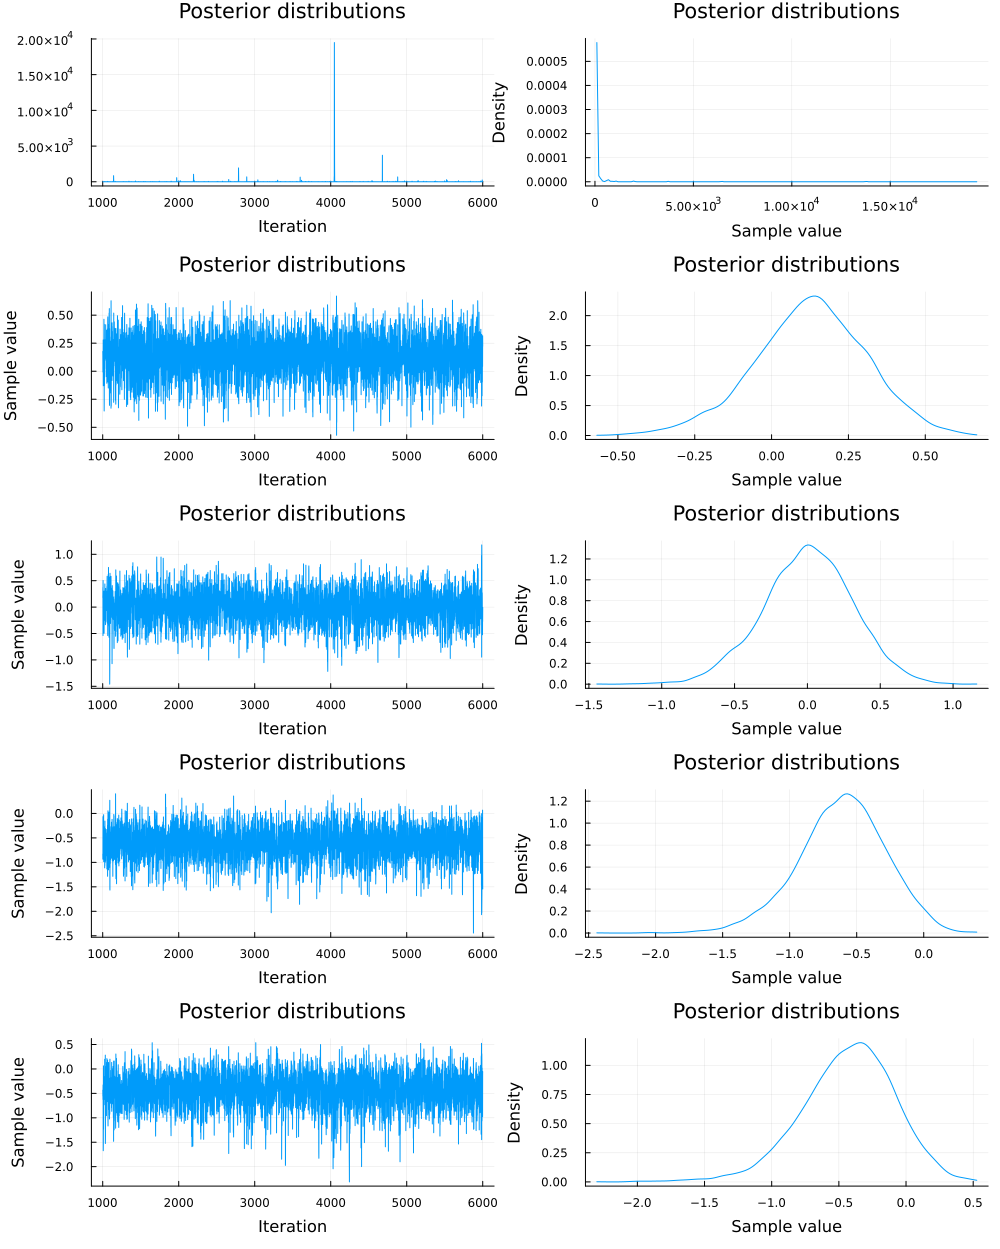

In [40]:
using StatsPlots
plot(chain[:,1:5,:], 
    vars = [:v, :l, :jitter], 
    title = "Posterior distributions", 
    label = ["v" "l" "jitter"], 
    legend = false)